# Gossip Girl

# Motivation 

Our motivation for doing this project is to explore the copmlex charachters in the well known tv show that we have grown up with: Gossip Girl by using a set of tools and techniques we have learned in the the Social Graphs course. 

Gossip Girl is a TV-series following complex and intervining charachters lifes. Troughout the series the charachters has countless realationships, enemies,freinds and family memebers. It is impossible for the viuer to keep track. We want to unpack and analyze the charachters relationships trouhgout the series

### 1.1 Data set 
Our data set consists of data from https://gossipgirl.fandom.com/wiki/Gossip_Girl_Wiki witch is a wiki. 

The wiki pages that has been scraped and used:
- /Category:Characters
- /{Name of the Charachter}
- /Category:Females
- /Category:Males
- /Category:Van_der_Woodsen_family
- /Category:Humphrey_family
- /Category:Bass_Family

### 1.2 Why did we choose this dataset? 
We have grown up watching this show, and always struggeled keeping track on the families, the complex realationships and the charachters change of personality. We wanted to get a unique insight, and taught it would be fun to analyze this TV-show. The TW-show we have choosen has mainly female or femeine viewers. Our line of work and study is quite male dominated. We are two girls that want to bring more femeninity to programming, and therefor found it fitting choosing this TV-series as our dataset.

### 1.3 What was our goal for the dataset? 

    

What is your dataset?
Why did you choose this/these particular dataset(s)?
What was your goal for the end user's experience?

In [79]:
#Import data fetching and cleaning 
import requests, re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import lxml
import itertools
import copy

#Import data Network
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import warnings

# Imports text analyze 
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pylab
import random
from nltk.corpus import stopwords
from PIL import Image

# Imports senntiment
from nltk.sentiment import SentimentIntensityAnalyzer

from bs4 import Comment
from urllib.request import urlopen
 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olinezachariassen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data and basic stats
### List of charachters/ nodes

In [80]:
#Get list 

warnings.filterwarnings('ignore')


def CharacterList(url):
    websiteURL =  requests.get(url)
    soup = BeautifulSoup(websiteURL.text)
    characterGallery = soup.find_all('div',{'class':'category-page__members'})
    characters = []

    for character in characterGallery:

        images = character.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            characters.append(characterName)
            characters.append('Blair Waldorf')
            

    return characters


ListOfCharacter = CharacterList("https://gossipgirl.fandom.com/wiki/Category:Characters")
#ListOfCharacter

ListCharachters   = set(ListOfCharacter)

print("number of nodes: ", len(ListCharachters))




number of nodes:  113


### Remove non human nodes

In [81]:
toRemove = ["relationship", 'Gossip', 'Season', 'Tripp\xa0Vanderbilt','Social Media', 'Breakfast', 'Melanie91' ]

toRemove = set(toRemove)
listCharachters = [c for c in ListCharachters if not any(r in toRemove for r in c.split())]

print("number of nodes after stripping: ", len(listCharachters))


number of nodes after stripping:  97


### Create DF 

In [82]:

DF = pd.DataFrame(columns=['Character', 'Family', 'Romances', 'Friends', 'Enemies','size/Relastionship', 'gender/color', 'description'])
DF['Character'] = listCharachters





### Get edges and relationships

In [83]:

def getRelationship(nodes):
    
    for i, charachter in enumerate(nodes):
        url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}")
        soup = BeautifulSoup(url.text)

        Family= []
        Romances = []
        Friends = []
        Enemies = []

        try:
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            family =  infoBox.findAll('div', {'data-source':"Family (only TV series)"}) 

            FamilyNames = re.findall('title="(.*?)"',str(family))

            FamilyNames = set(FamilyNames)
            for name in FamilyNames:
                if name in ListCharachters:
                    Family.append(name) 
        except: 
            Family= []
        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            romances = infoBox.findAll('div', {'data-source':"Romances (only TV series)"})

            romanceNames = re.findall('title="(.*?)"',str(romances))
            romanceNames = set(romanceNames)
            for name in romanceNames:
                if name in ListCharachters:
                    Romances.append(name) 

        except:
            Romances = []
        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            friends = infoBox.findAll('div', {'data-source':"Friends (only TV series)"})

            friendsNames = re.findall('title="(.*?)"',str(friends))
            friendsNames = set(friendsNames)
            for name in friendsNames:
                if name in ListCharachters:
                    Friends.append(name) 

        except:
            Friends = []

        try: 
            infoBox = soup.findAll('section',{'class':'pi-item pi-group pi-border-color'})[1]
            enemies = infoBox.findAll('div', {'data-source':"Enemies (only TV series)"})

            enemiesNames = re.findall('title="(.*?)"',str(enemies))
            enemiesNames = set(enemiesNames)
            for name in enemiesNames:
                if name in ListCharachters:
                    Enemies.append(name) 
        except:
            Enemies = []

        DF['Family'][i] = Family
        DF['Romances'][i] = Romances
        DF['Friends'][i] = Friends
        DF['Enemies'][i] = Enemies
        DF['size/Relastionship'][i] = len(Family) + len(Romances) + len(Friends) + len(Enemies)



### Clean text 

In [84]:
def getCleanText(charachter):
    
    try: 

        #for i, charachter in enumerate(charachters10):
        url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}#Television_Series")
        soup = BeautifulSoup(url.text)

        infoBox = soup.findAll('div',{'class':'main-container'})
        infoBox = soup.findAll('div',{'class':'resizable-container'})
        infoBox = soup.findAll('div',{'class':'page has-right-rail'})
        infoBox = soup.findAll('div',{'class':'page-content'})
        infoBox = soup.findAll('p')[3:]



        letters_only = re.sub("[^a-zA-Z]"," ",str(infoBox))
        text = re.sub(r'\<.*?\>', '', letters_only)
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = text.lower()
        text_tokens = word_tokenize(text)
        tokens = [word.lower() for word in text_tokens]
        tokens = [word for word in text_tokens if not word in stopwords.words()]
        removeList = ['p', 'a', 's','title','href','wiki']
        tokens = [word for word in text_tokens if not word in removeList]
        
        return tokens
    
    except:
        
        return []

### Gets gender 

In [85]:
def getGenders():
    websiteURL =  requests.get("https://gossipgirl.fandom.com/wiki/Category:Females")
    wesiteURL2 = requests.get("https://gossipgirl.fandom.com/wiki/Category:Males")
    soup = BeautifulSoup(websiteURL.text)
    soup2 = BeautifulSoup(wesiteURL2.text)
    FemaleGallery = soup.find_all('div',{'class':'category-page__members'})
    MaleGallery = soup2.find_all('div',{'class':'category-page__members'})
    females = []
    males = []
    for female in FemaleGallery:

        images = female.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            females.append(characterName)
            
    for male in MaleGallery:

        images = male.findAll("img")
        for image in images:
            try:
                characterName = image.get("alt")
            except:
                pass

            males.append(characterName)

    for i  in range(len(listCharachters)):
        if listCharachters[i] in females:
            DF['gender/color'][i] = 'pink'
        elif listCharachters[i] in males:
            DF['gender/color'][i] = '#add8e6'
        else: 
            DF['gender/color'][i] = 'grey'
            

getGenders()
getRelationship(listCharachters)
DF


Character                                             Family  \
0       Kati Farkas                                                 []   
1   Georgina Sparks                                    [Philip Becker]   
2     Blair Waldorf  [Eleanor Waldorf, Jack Bass, Bart Bass, Sophie...   
3     Marcus Beaton                                 [Catherine Beaton]   
4         Bart Bass                [Henry Bass, Chuck Bass, Jack Bass]   
..              ...                                                ...   
92     Carol Rhodes  [Dan Humphrey, Eric van der Woodsen, Blair Wal...   
93  Alison Humphrey  [Serena van der Woodsen, Dan Humphrey, Jenny H...   
94  Colin Forrester                        [Juliet Sharp, Ben Donovan]   
95      Audrey Hope                                                 []   
96  Rebecca Sherman                                                 []   

                                             Romances  \
0                                                  []   
1   [Jack Bass, Dan Humphrey, Philip Becker, Chuck...   
2   [Blair–Nate relationship, Jack Bass, Dan Humph...   
3                   [Catherine Beaton, Blair Waldorf]   
4            [Elizabeth Fisher, Lily van der Woodsen]   
..                                                ...   
92                          [William van der Woodsen]   
93                                   [Rufus Humphrey]   
94                           [Serena van der Woodsen]   
95                           [Max Wolfe, Aki Menzies]   
96                                                 []   

                                              Friends  \
0                 [Isabel Coates, Jessica Leitenberg]   
1   [Blair Waldorf, Jenny Humphrey, Dan Humphrey, ...   
2   [Georgina Sparks, Dan Humphrey, Jenny Humphrey...   
3                                        [Chuck Bass]   
4                                       [Diana Payne]   
..                                                ...   
92                                                 []   
93                                                 []   
94                                                 []   
95  [Aki Menzies, Max Wolfe, Julien Calloway, Obie...   
96                                                 []   

                                              Enemies size/Relastionship  \
0                                                  []                  2   
1   [Vanessa Abrams, Poppy Lifton, Eric van der Wo...                 14   
2   [Juliet Sharp, Beatrice Grimaldi, Vanessa Abra...                 32   
3                                                  []                  4   
4   [Rufus Humphrey, Chuck Bass, Jack Bass, Blair ...                 10   
..                                                ...                ...   
92                [Lily van der Woodsen, Ivy Dickens]                 12   
93                             [Lily van der Woodsen]                  5   
94                                                 []                  3   
95                                                 []                  6   
96                                                 []                  0   

   gender/color description  
0          pink         NaN  
1          pink         NaN  
2          pink         NaN  
3       #add8e6         NaN  
4       #add8e6         NaN  
..          ...         ...  
92         grey         NaN  
93         pink         NaN  
94      #add8e6         NaN  
95         pink         NaN  
96         pink         NaN  

[97 rows x 8 columns]

# Network

### help functions

In [86]:
## help function 

#get edge colors
def getEdgeColors(edges, edgeListFamily, edgeListRomances, edgeListFriends):
    colors = []
    for e in edges:
        if e in edgeListFamily:
            colors.append("grey")
        elif e in edgeListRomances:
            colors.append("pink")
        elif e in edgeListFriends:
            colors.append("blue")
        else: 
            colors.append("purple")
    return colors

def getGender(node):
    return DF['gender/color'][listCharachters.index(node)]

def getSize(node):
    return DF['size/Relastionship'][listCharachters.index(node)]

### Creates the whole network

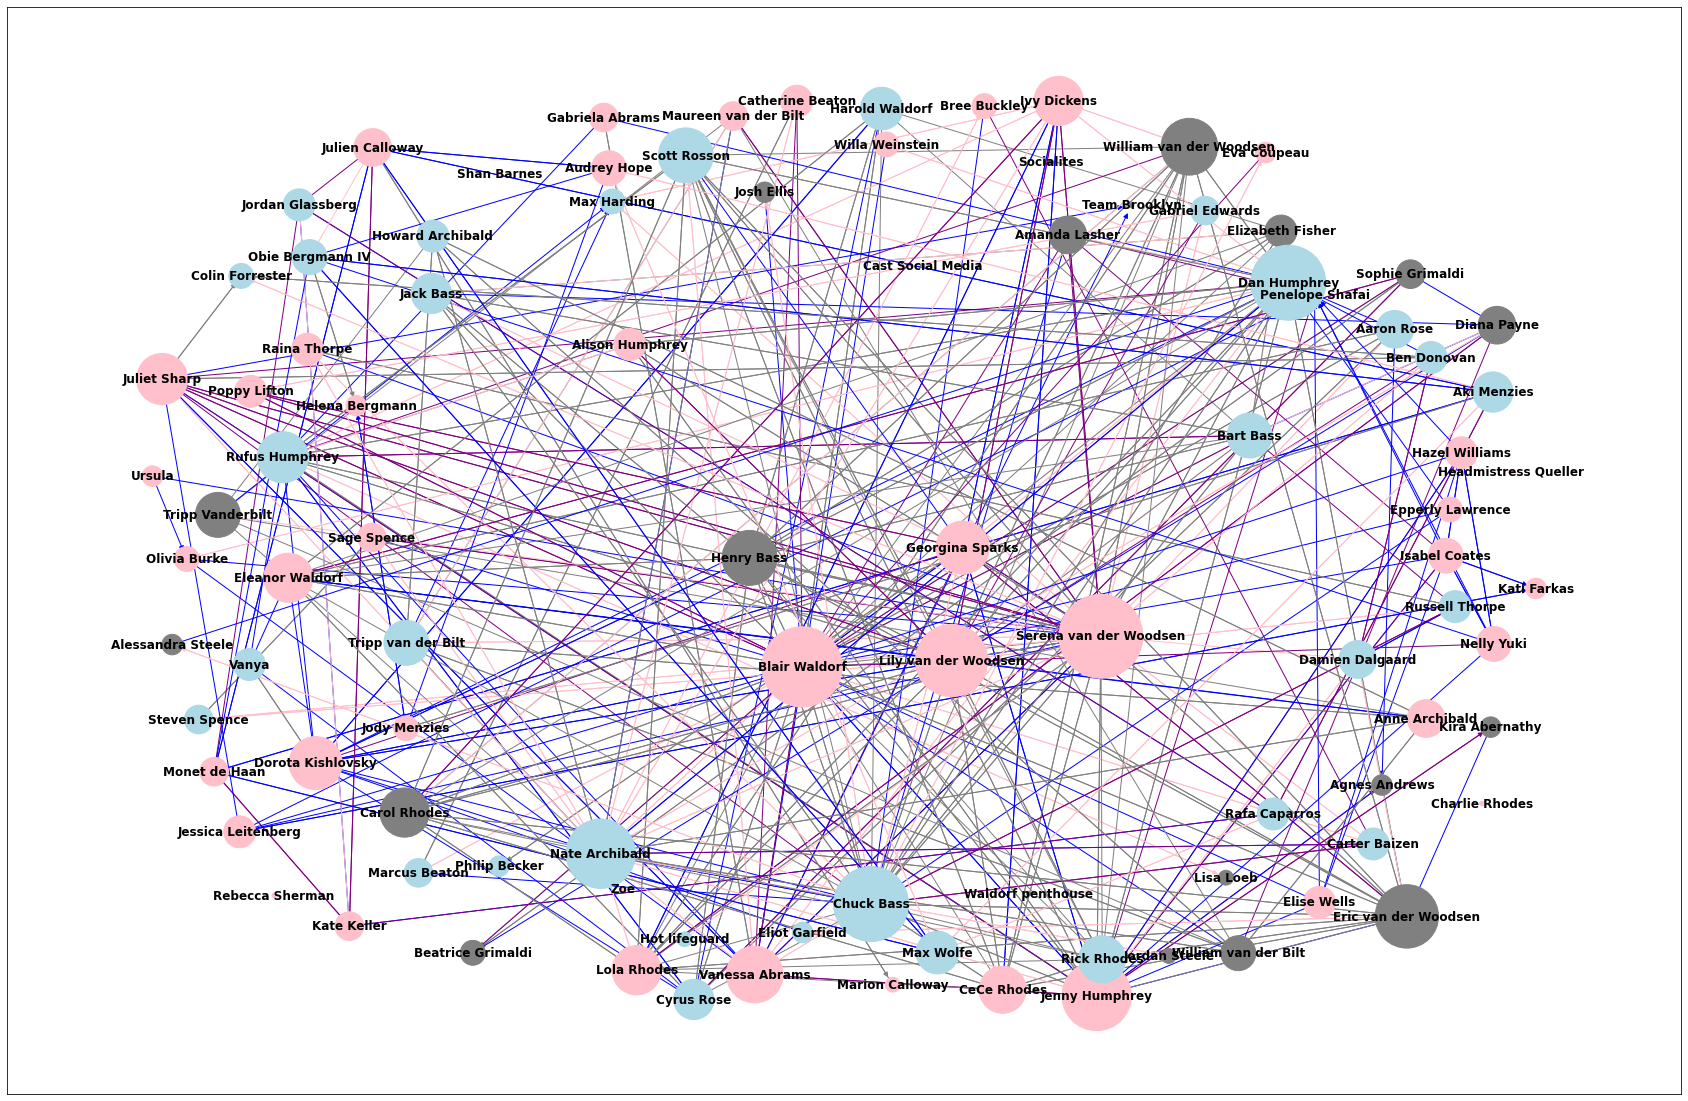

In [88]:
## create network with nodes and edges
edgeListFamily = []
edgeListRomances = []
edgeListFriends = []
edgeListEnemies = []


def createNetwork():

    edgeListFamily = []
    edgeListRomances = []
    edgeListFriends = []
    edgeListEnemies = []
    for i in range(len(listCharachters)):
        for j in DF['Family'][i]:
            if(j in listCharachters):
                edgeListFamily.append((listCharachters[i],j))

        for j in DF['Romances'][i]:
            if(j in listCharachters):
                edgeListRomances.append((listCharachters[i],j))

        for j in DF['Friends'][i]:
            if(j in listCharachters):
                edgeListFriends.append((listCharachters[i],j))

        for j in DF['Enemies'][i]:
            if(j in listCharachters):
                edgeListEnemies.append((listCharachters[i],j))


    fig, ax = plt.subplots()
    fig.set_size_inches(30,20)

    G = nx.DiGraph()
    G.add_nodes_from(listCharachters)
    G.add_edges_from(edgeListFamily)
    G.add_edges_from(edgeListRomances)
    G.add_edges_from(edgeListFriends)
    G.add_edges_from(edgeListEnemies)



    sizes = DF['size/Relastionship']
    gender = DF['gender/color']
    nodesizes = [int(s)*200+20 for s in sizes]
    


    pos = nx.spring_layout(G, k=10*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos=pos, node_size = nodesizes, node_color= gender )
    nx.draw_networkx_edges(G,pos=pos, width=1, edge_color=getEdgeColors(G.edges, edgeListFamily, edgeListRomances, edgeListFriends))
    nx.draw_networkx_labels(G,pos=pos, font_weight='bold',font_color='black')
    plt.show()
    
    
    return G  

#get edge colors
def getEdgeColors(edges, edgeListFamily, edgeListRomances, edgeListFriends):
    colors = []
    for e in edges:
        if e in edgeListFamily:
            colors.append("grey")
        elif e in edgeListRomances:
            colors.append("pink")
        elif e in edgeListFriends:
            colors.append("blue")
        else: 
            colors.append("purple")
    return colors
    

TotalNetwork = createNetwork()



## Info about graph 

In [89]:

print("Number of edges in the directed graph is", G.number_of_edges())

totalNetwork = G.to_undirected()

print("Number of edges in the Undirected graph is", H.number_of_edges())

Number of edges in the directed graph is 591
Number of edges in the Undirected graph is 357


### Create Network for one node/charachter


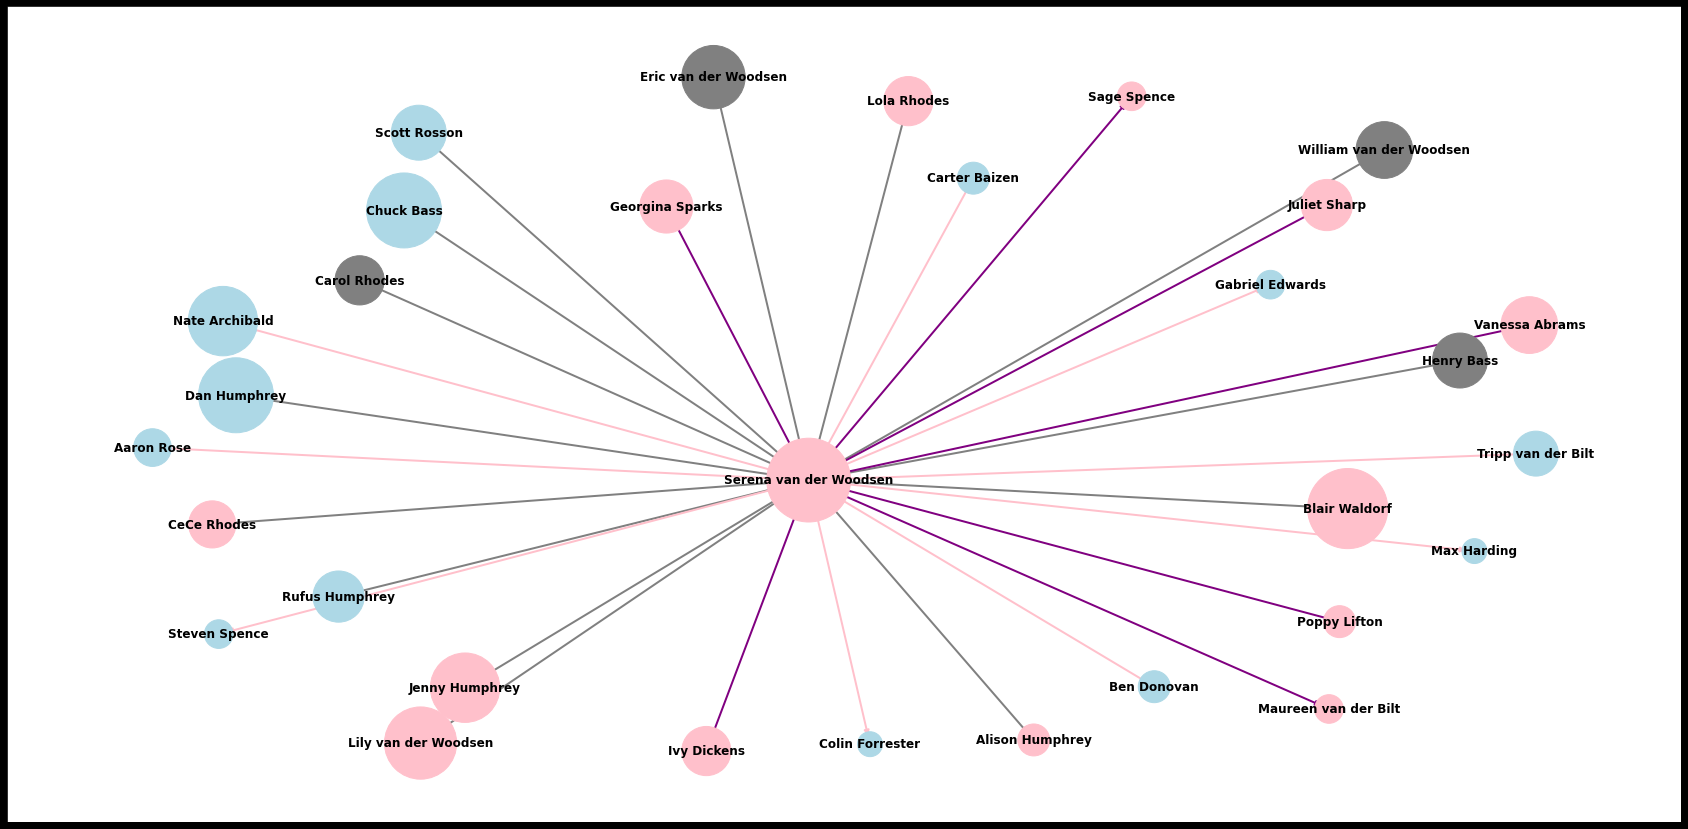

Number of edges in the Undirected graph is 30


<Figure size 432x288 with 0 Axes>

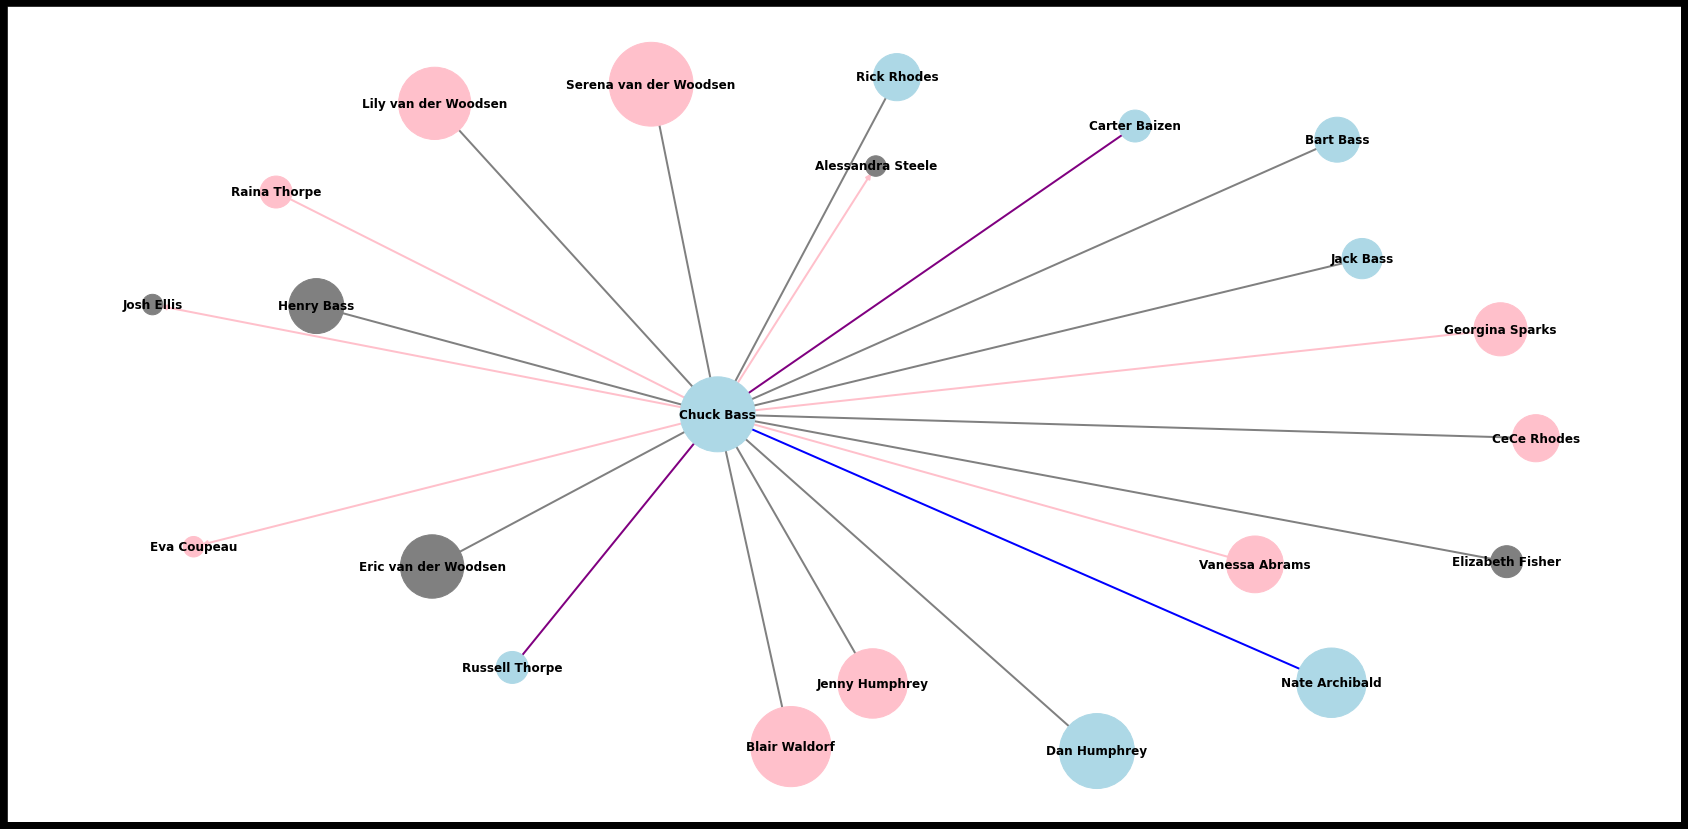

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

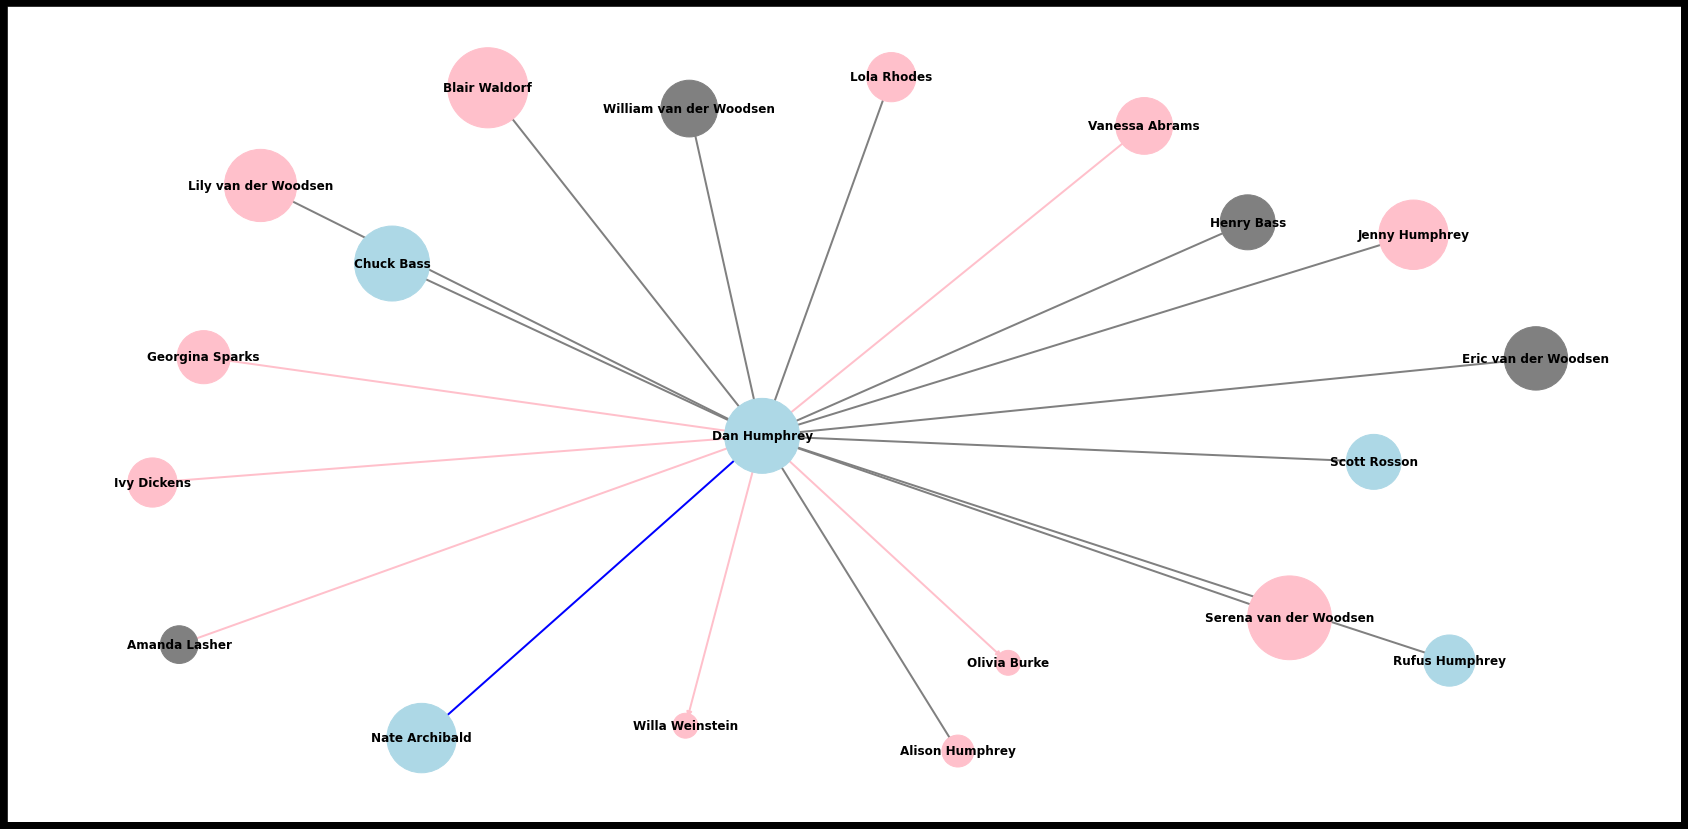

Number of edges in the Undirected graph is 19


<Figure size 432x288 with 0 Axes>

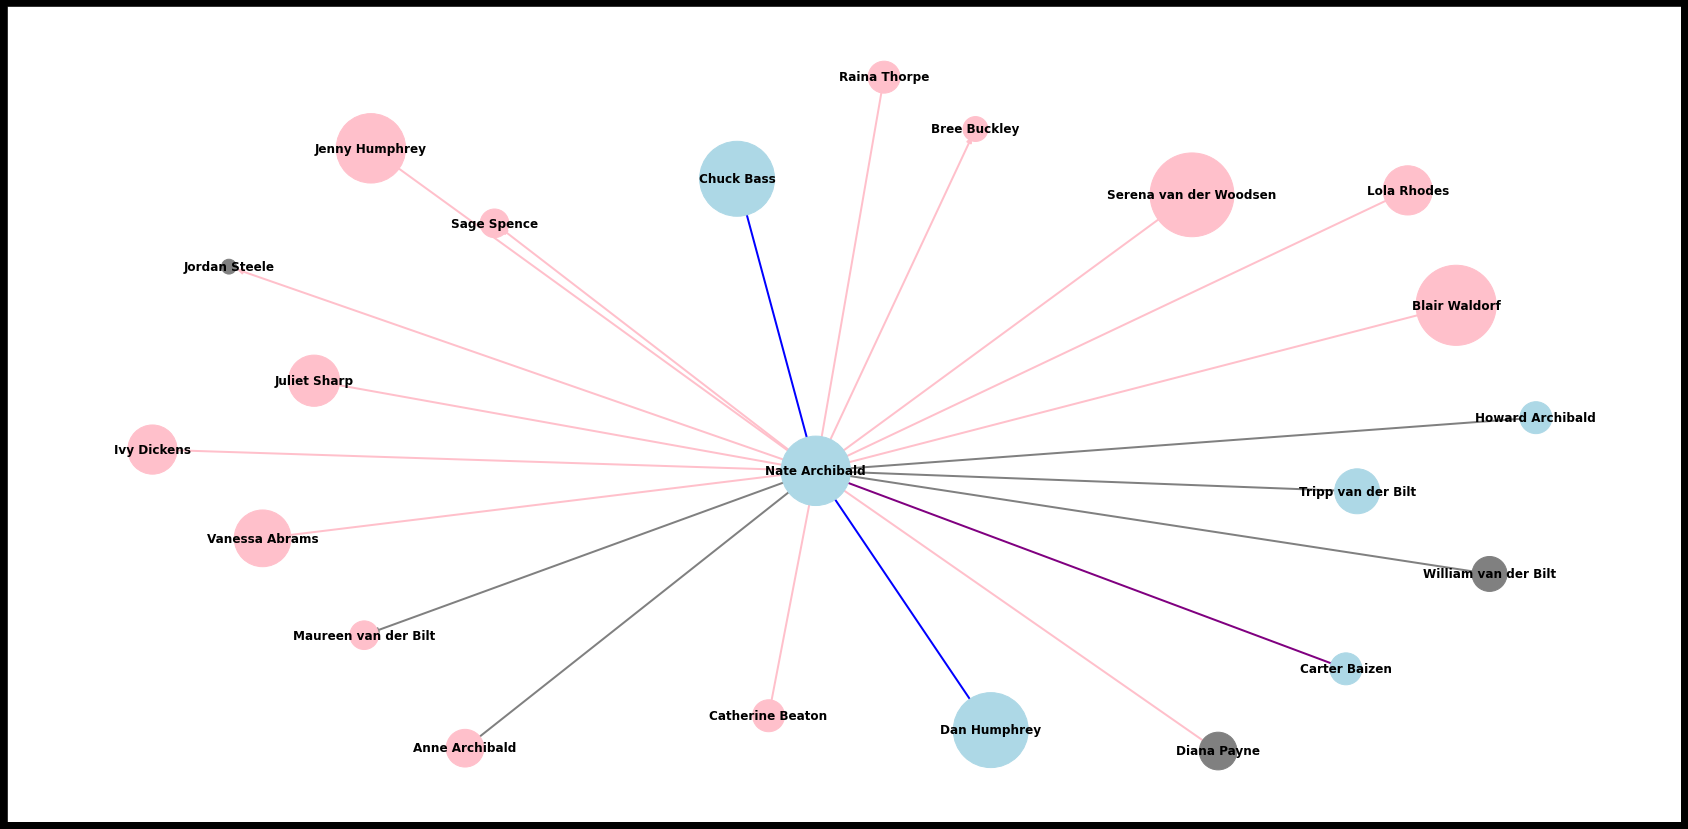

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

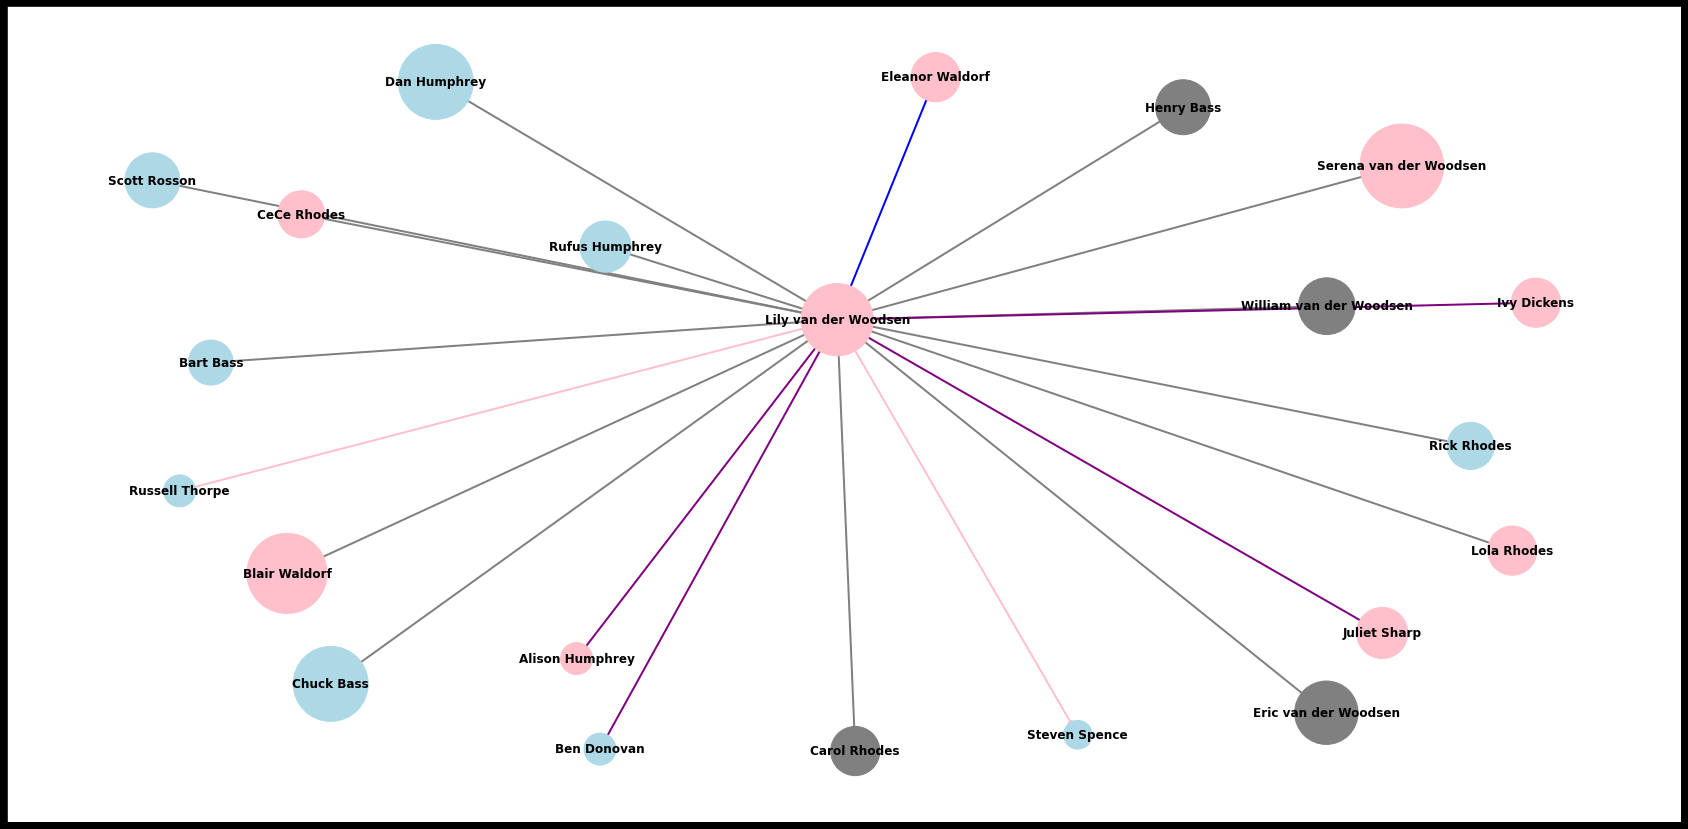

Number of edges in the Undirected graph is 21


<Figure size 432x288 with 0 Axes>

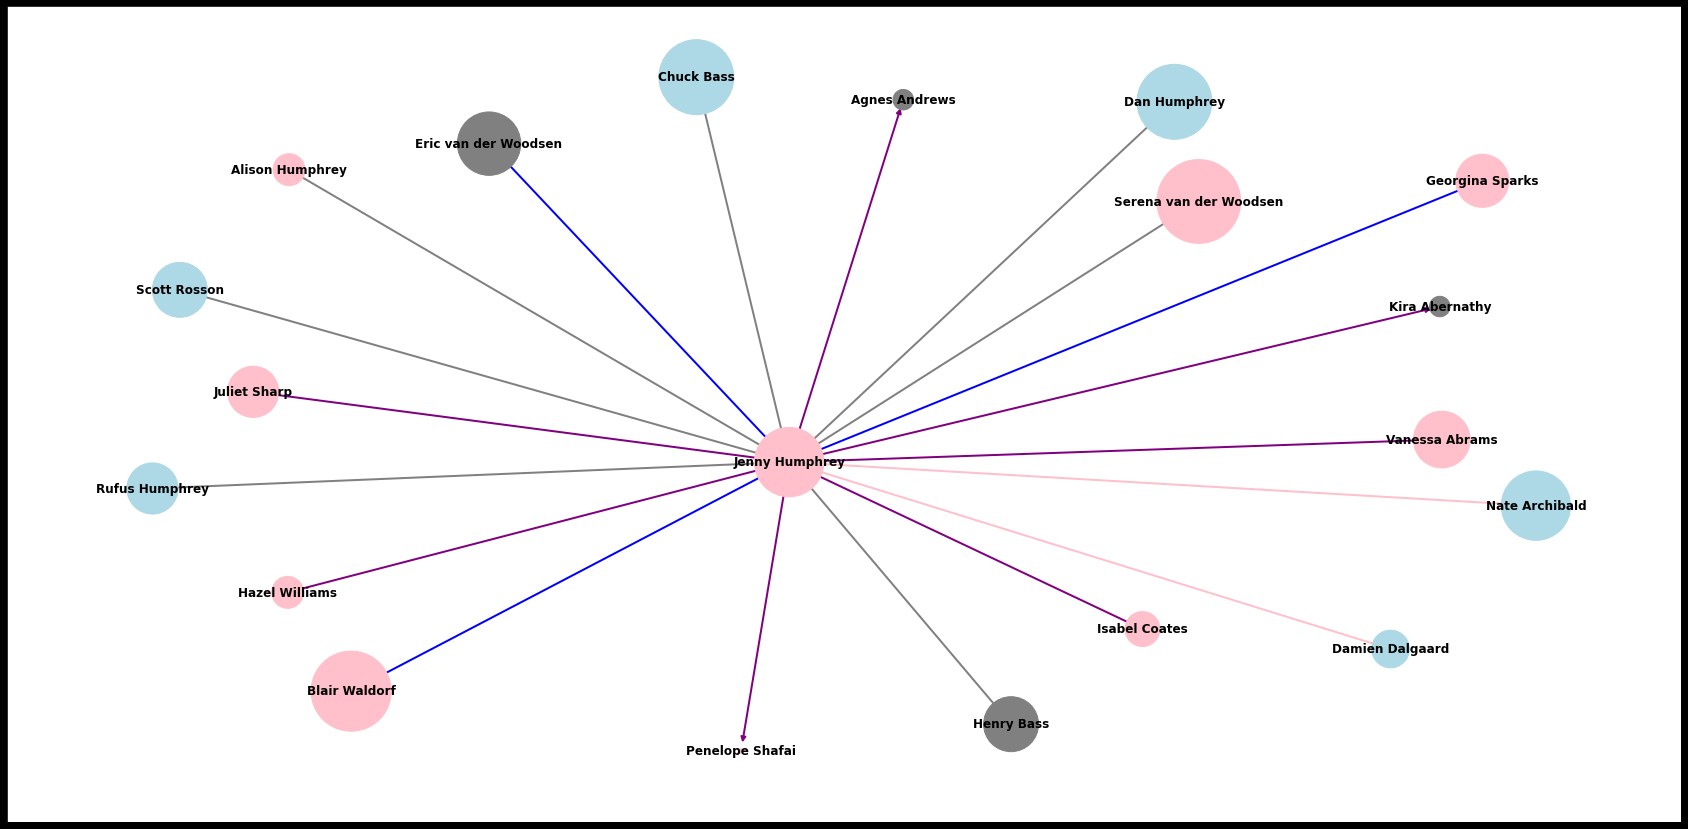

Number of edges in the Undirected graph is 19


<Figure size 432x288 with 0 Axes>

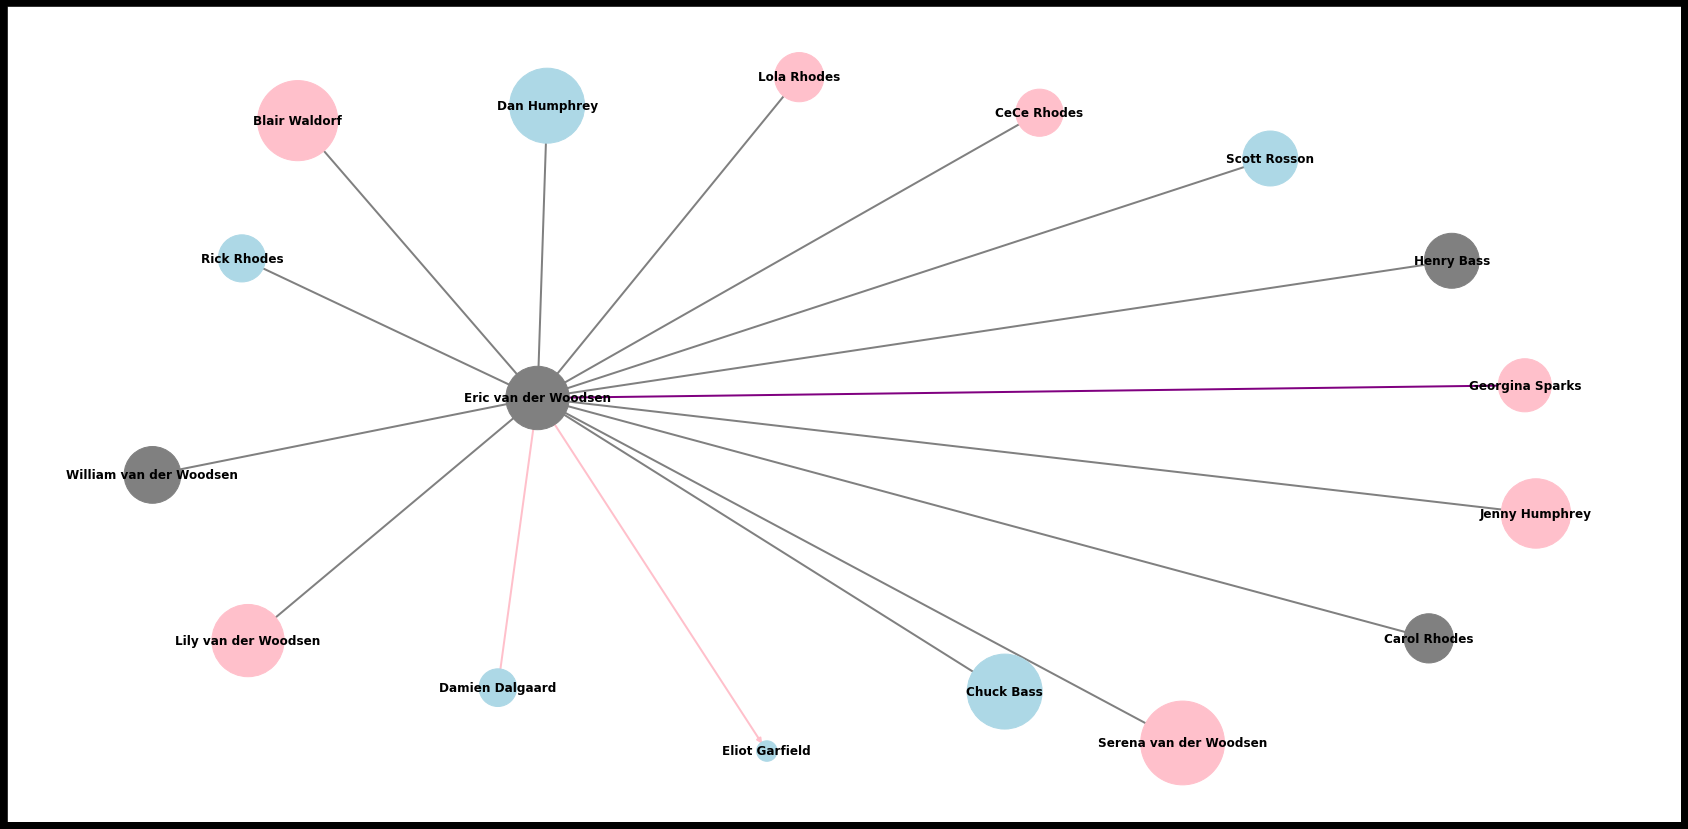

Number of edges in the Undirected graph is 16


<Figure size 432x288 with 0 Axes>

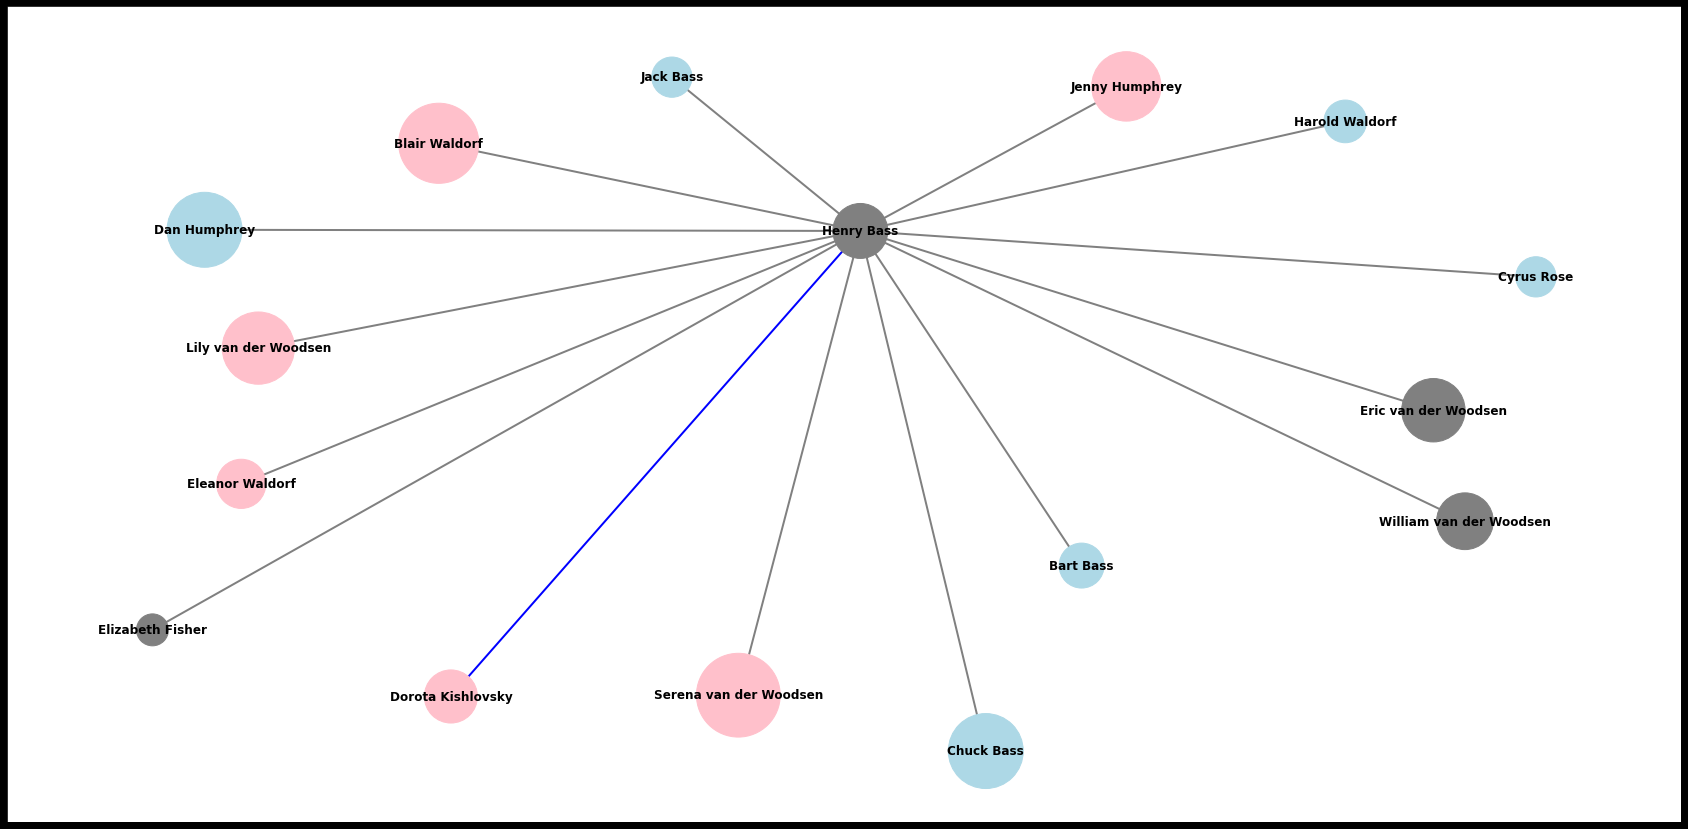

Number of edges in the Undirected graph is 15


<Figure size 432x288 with 0 Axes>

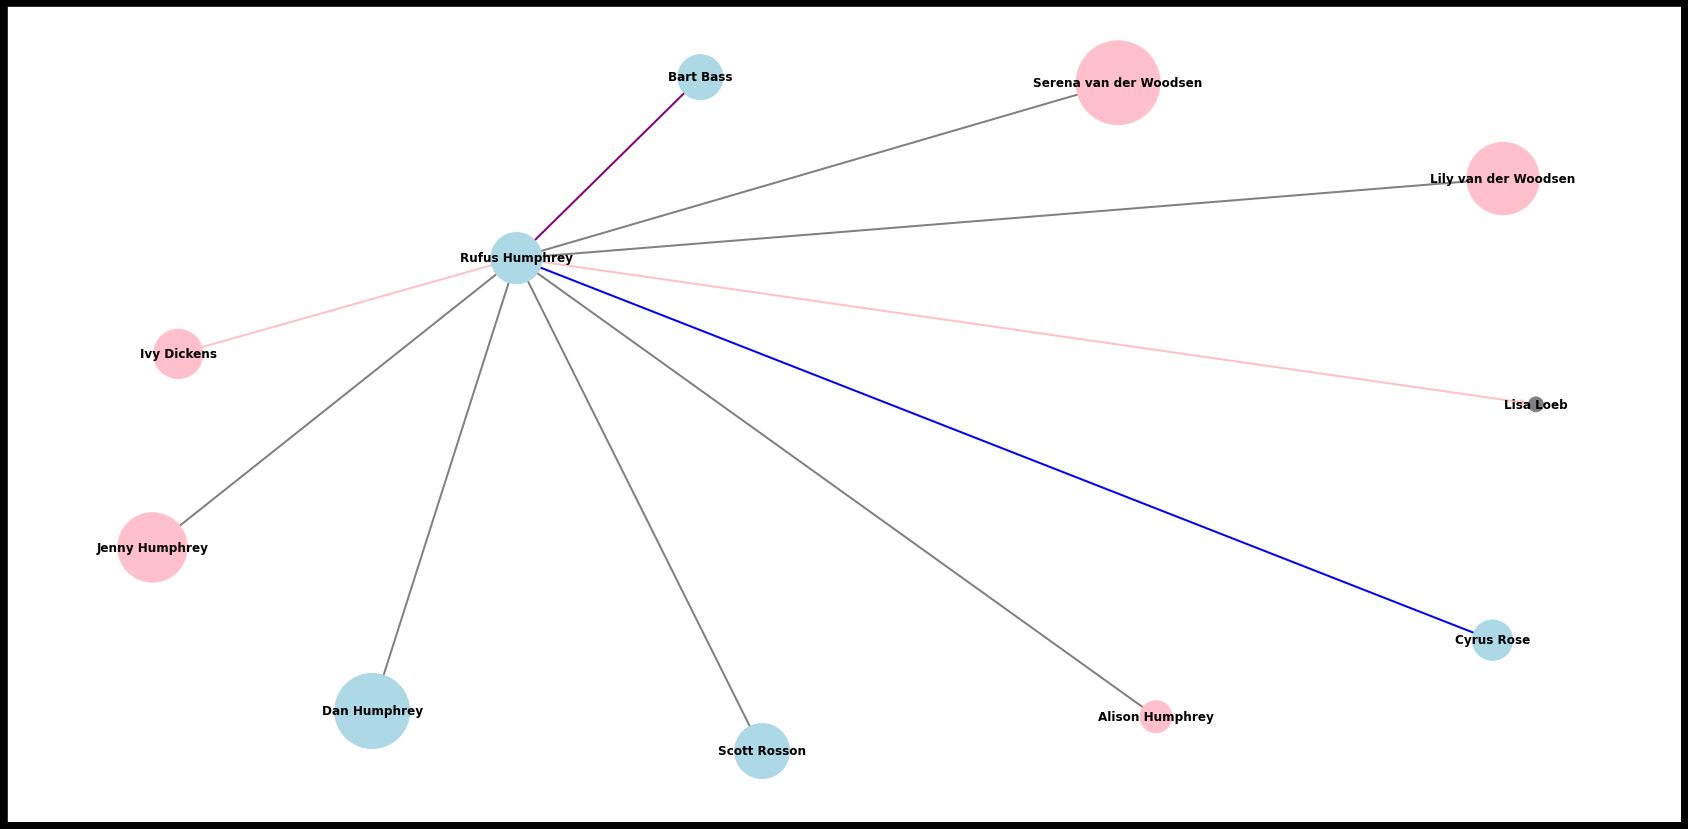

Number of edges in the Undirected graph is 10


<Figure size 432x288 with 0 Axes>

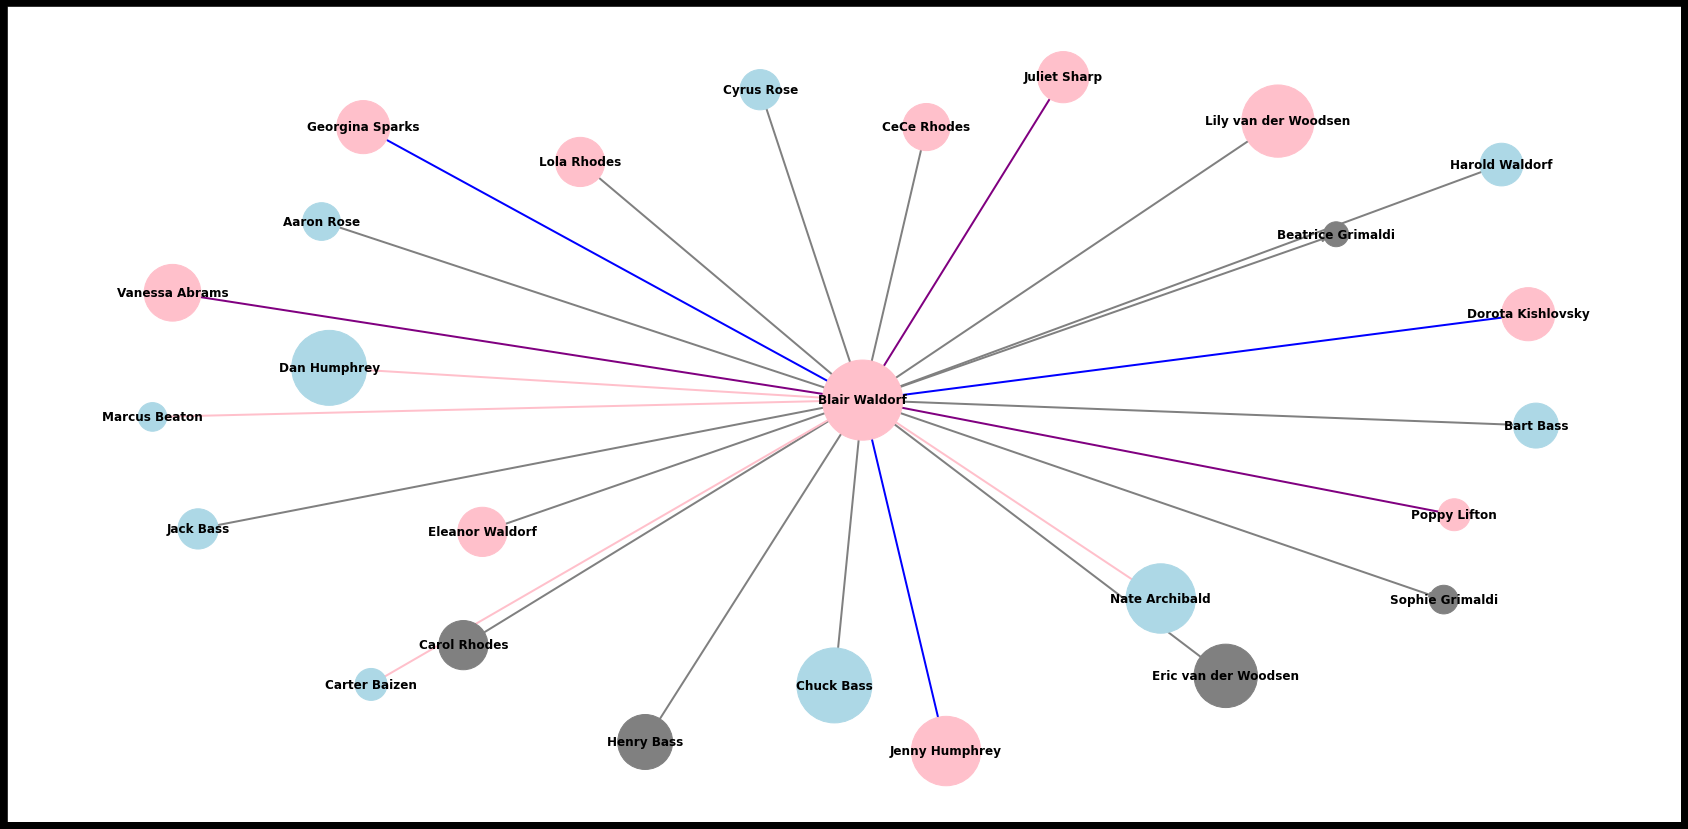

Number of edges in the Undirected graph is 25


<Figure size 432x288 with 0 Axes>

In [92]:
## Create network for one node with belonging neidgbors and edges

def createNetwork2(list):
    
    G = nx.DiGraph()
    
    edgeListFamily = []
    edgeListRomances = []
    edgeListFriends = []
    edgeListEnemies = []
    
    sizes = []
    gender = []
    for node in list:
        i = listCharachters.index(node)
        for j in DF['Family'][i]:
            if(j in listCharachters and j not  in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListRomances or edgeListFriends or edgeListEnemies:
                    edgeListFamily.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Romances'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListFriends or edgeListEnemies:
                    edgeListRomances.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Friends'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListRomances or edgeListEnemies:
                    edgeListFriends.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))

        for j in DF['Enemies'][i]:
            if(j in listCharachters and j not in G.nodes):
                G.add_node(j)
                edge = listCharachters[i],j
                if edge not in edgeListFamily or edgeListFriends or edgeListRomances:
                    edgeListEnemies.append((edge))
                    sizes.append(getSize(j))
                    gender.append(getGender(j))
        
        #If we only want the network of one node
        if len(list) == 1:
            sizes.append(DF['size/Relastionship'][i])
            gender.append(DF['gender/color'][i])

    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    fig.set_facecolor('black')
    
    G.add_edges_from(edgeListFamily)
    G.add_edges_from(edgeListRomances)
    G.add_edges_from(edgeListFriends)
    G.add_edges_from(edgeListEnemies)

    nodesizes = [int(s)*200+20 for s in sizes]
    
    pos = nx.spring_layout(G, k=6*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw_networkx_nodes(G, pos=pos, node_size = nodesizes, node_color= gender )
    nx.draw_networkx_edges(G,pos=pos, width=2, edge_color=getEdgeColors(G.edges, edgeListFamily, edgeListRomances, edgeListFriends))
    nx.draw_networkx_labels(G,pos=pos, font_weight='bold',font_color='black')
    plt.show()
    fig=plt.figure()

    fig.savefig(list[0]+'.png', bbox_inches='tight')
    
    H = G.to_undirected()
    
    print("Number of edges in the Undirected graph is", H.number_of_edges())
    

charachters10 = ['Serena van der Woodsen', 'Chuck Bass', 'Dan Humphrey','Nate Archibald','Lily van der Woodsen','Jenny Humphrey','Eric van der Woodsen','Henry Bass','Rufus Humphrey', 'Blair Waldorf']

for c in charachters10:
    createNetwork2([c])



### Gets Network for family 

In [98]:
VanDerWoodsen = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Van_der_Woodsen_family')))
Humphrey = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Humphrey_family')))
Bass = list(set(CharacterList('https://gossipgirl.fandom.com/wiki/Category:Bass_Family')))
VanDerWoodsen.remove('Chuck–Serena relationship')
Humphrey.remove('Milo Sparks')
Bass.remove('The Bass Family')
Bass.remove('Chuck–Serena relationship')

print('Van der Woodsen')
createNetwork2(VanDerWoodsen)
print('Humphrey')
createNetwork2(Humphrey)
print('Bass')
createNetwork2(Bass)





TypeError: 'list' object is not callable

#### Number of edges in Van der Woodsen: 48 
#### Number of edges in Humprey: 49
#### Number of edges in Bass: 41

### Humprey is the most conected family

### Info about graph 

### 10 most conected charachters

In [93]:


DF2 = pd.DataFrame(columns=['Character', 'Degree'])
top10 = []
degree = []
for c in SortedG[:10]:
    top10.append(c[0])
    degree.append(c[1])
    
DF2['Character'] = top10 
DF2['Degree'] = degree

DF2


Character  Degree
0  Serena van der Woodsen      69
1           Blair Waldorf      64
2              Chuck Bass      54
3            Dan Humphrey      46
4    Lily van der Woodsen      44
5          Nate Archibald      44
6          Jenny Humphrey      39
7    Eric van der Woodsen      33
8              Henry Bass      31
9          Rufus Humphrey      25

# Word clouds for the top 10 most conected components 



In [94]:

charachterDict = {}
for character in top10:
    charachterDict[character] = getCleanText(character)
    i = listCharachters.index(character)
    DF['description'][i] =charachterDict[character] 

DF.to_csv('Data.csv', index=False)


## wordCloud

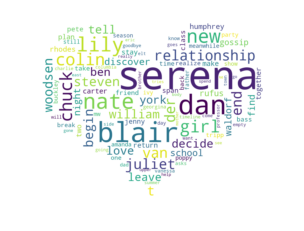

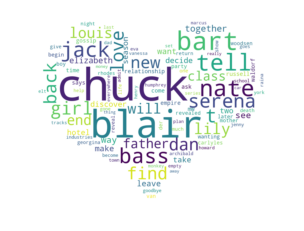

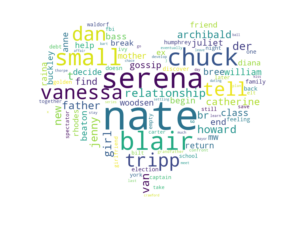

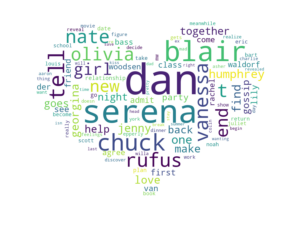

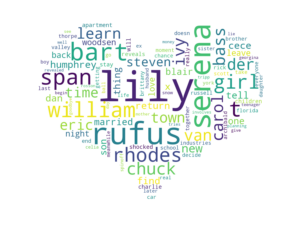

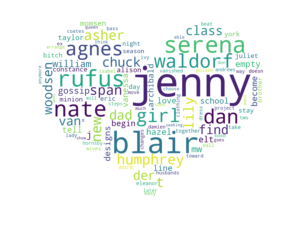

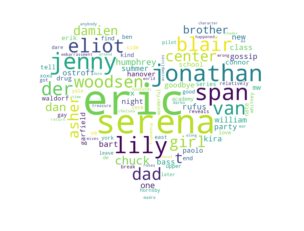

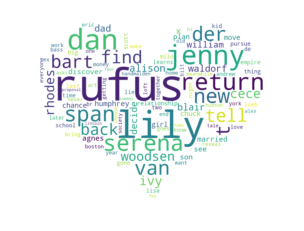

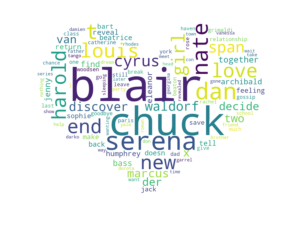

In [95]:
kiss_mask = np.array(Image.open("kiss4.png"))

def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(30,60))


def term_count(titleList):
    termCount = {}
    for word in titleList:
        if word in termCount:
            termCount[word] +=1
        else: 
            termCount[word]= 1 

    return termCount

collectionText = nltk.TextCollection([charachterDict['Serena van der Woodsen'], charachterDict['Chuck Bass'], charachterDict['Nate Archibald'],charachterDict['Dan Humphrey'],charachterDict['Lily van der Woodsen'], charachterDict['Jenny Humphrey'], charachterDict['Eric van der Woodsen'], charachterDict['Henry Bass'],charachterDict['Rufus Humphrey'], charachterDict['Blair Waldorf']])



def idf(text):
    idf= {}
    for word in text:
        idf[word] = text.idf(word)
    return idf
        

def tc_idf(title):
    idfs = idf(collectionText)
    tc_idf= {}
    for word in charachterDict[title]:
        tc_idf[word] = int(math.ceil(idfs[word])) * term_count(charachterDict[title])[word]
    return tc_idf

Serena_tc_idf= tc_idf('Serena van der Woodsen')
Chuck_tc_idf= tc_idf('Chuck Bass')
Nate_tc_idf= tc_idf('Nate Archibald')
Dan_tc_idf= tc_idf('Dan Humphrey')
Lily_tc_idf= tc_idf('Lily van der Woodsen')
Jenny_tc_idf= tc_idf('Jenny Humphrey')
Eric_tc_idf= tc_idf('Eric van der Woodsen')
#Henry_tc_idf= tc_idf('Henry Bass')
Rufus_tc_idf= tc_idf('Rufus Humphrey')
Blair_tc_idf= tc_idf('Blair Waldorf')
tc_idfs = [Serena_tc_idf, Chuck_tc_idf, Nate_tc_idf, Dan_tc_idf,Lily_tc_idf, Jenny_tc_idf,Eric_tc_idf, Rufus_tc_idf, Blair_tc_idf]
        
for tcidf in tc_idfs: 
  
    strng = ""
    for key,value in tcidf.items():
        strng+= ((key+ " ") * value)
    
    wordcloud = WordCloud(max_words=100, background_color="white", mask=kiss_mask, width =300, height = 200 , random_state=1, collocations=False).generate(strng)
    #wordcloud.recolor(color_func =pink_color_func, random_state = 3)
    img=plt.imshow(wordcloud, interpolation="bilinear")
    #plt.figure(figsize=(20,20), facecolor="k")

    plt.axis("off")
    plt.show()

## Sentiment analyses 
#### Witch character is the most romantic? 


### Who is a good or bad person? 

#### We will use sentiment analysis 

Positive reviews will be classified as +1, and negative reviews will be classified as -1.
We will classify all reviews with ‘Score’ > 3 as +1, indicating that they are positive.
All reviews with ‘Score’ < 3 will be classified as -1. Reviews with ‘Score’ = 3 will be dropped, because they are neutral


# Sentimet analyses

In [96]:
sia = SentimentIntensityAnalyzer()
NegPosComNeu = {}

for charachter in top10: 
    url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{charachter}#Television_Series")
    soup = BeautifulSoup(url.text)

    infoBox = soup.findAll('div',{'class':'main-container'})
    infoBox = soup.findAll('div',{'class':'resizable-container'})
    infoBox = soup.findAll('div',{'class':'page has-right-rail'})
    infoBox = soup.findAll('div',{'class':'page-content'})
    infoBox = soup.findAll('p')[3:]
    list = []
    sentences = re.split('[\.\?\!]\s*', str(infoBox))
    for sentence in sentences:
        letters_only = re.sub("[^a-zA-Z]"," ",str(sentence))

        text = re.sub(r'\<.*?\>', '', letters_only)
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = text.lower()
        text_tokens = word_tokenize(text)
        tokens = [word.lower() for word in text_tokens]
        tokens = [word for word in text_tokens if not word in stopwords.words()]
        removeList = ['p', 'a', 's', 'href',  'wiki']
        tokens = [word for word in text_tokens if not word in removeList]

        strng = " ".join(tokens)


        list.append(strng)
    sumC = 0 
    sumN = 0
    sumNeu = 0
    sumP = 0
    for sentence in list: 
        sentiment_dict = sia.polarity_scores(sentence)
        sumC += sentiment_dict['compound']
        sumN += sentiment_dict['neg']
        sumNeu += sentiment_dict['neu']
        sumP += sentiment_dict['pos']

    NegPosComNeu[charachter] = [sumC, sumN, sumNeu, sumP ]



<BarContainer object of 10 artists>

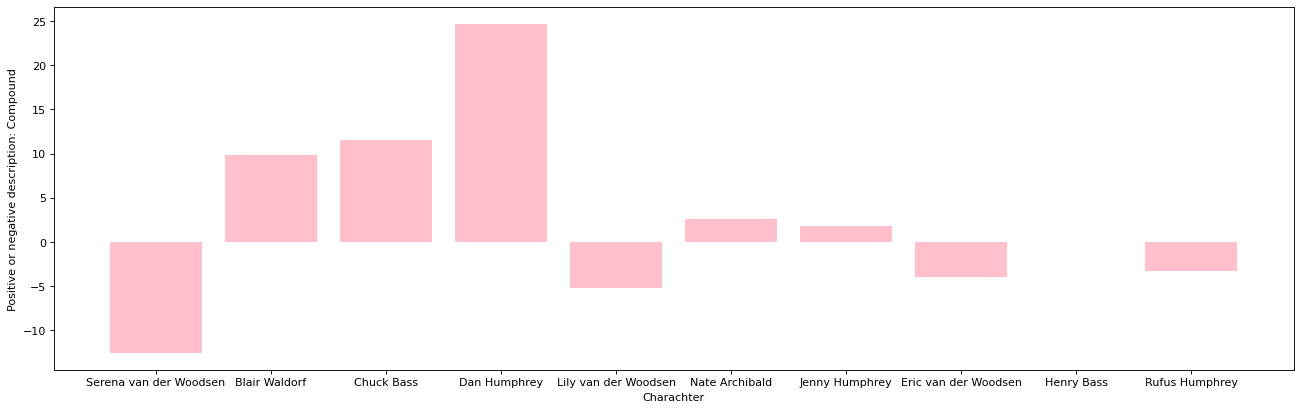

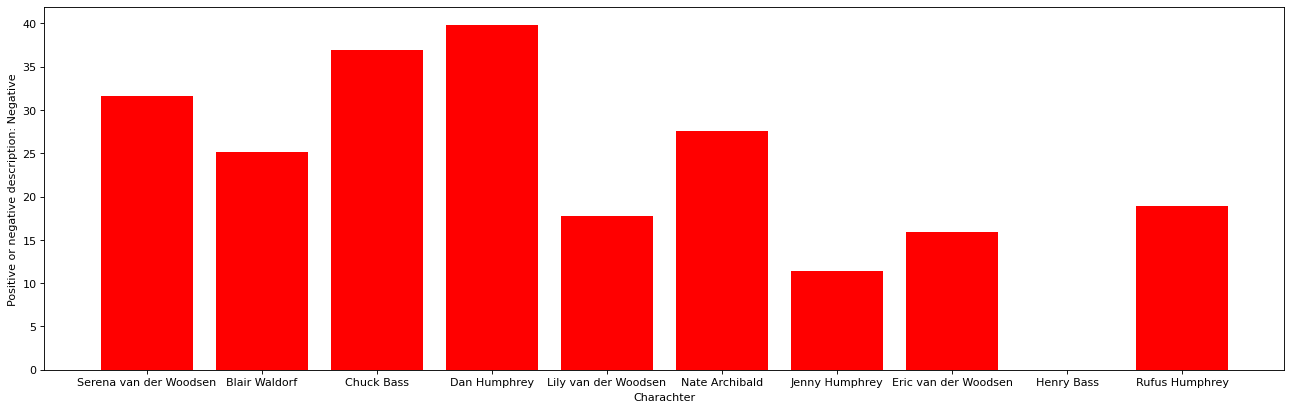

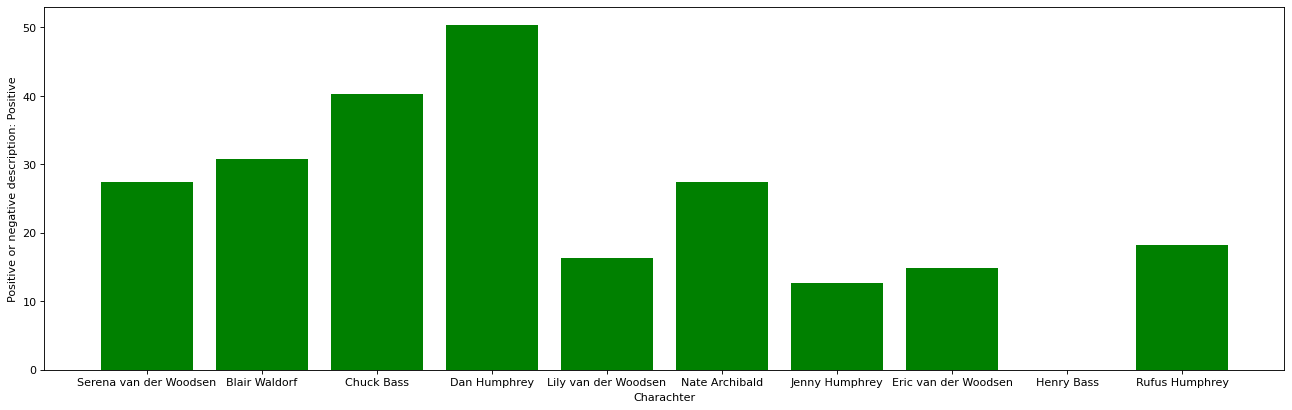

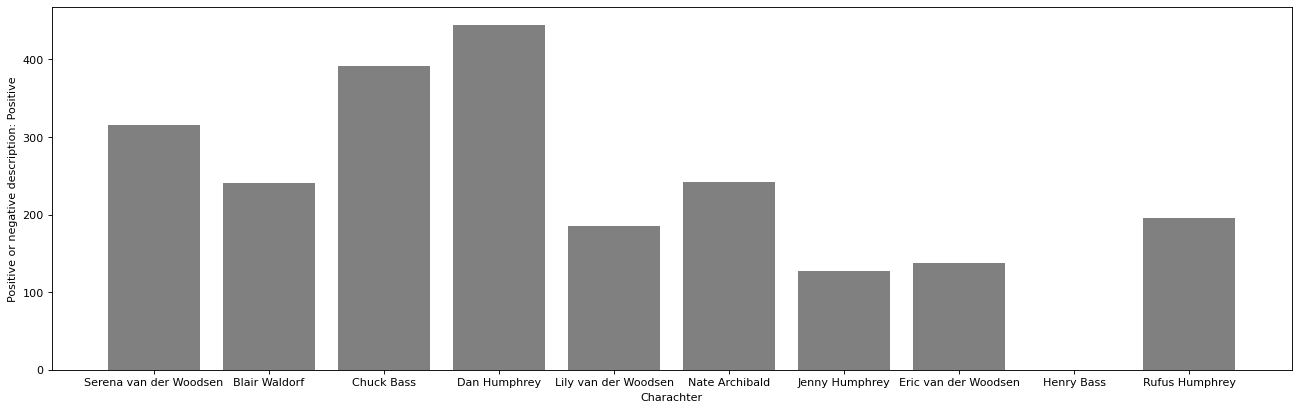

In [99]:
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Compound")
 
x = []
xn = []
xneu = []
xp = []
for key,value in NegPosComNeu.items():
    x.append(value[0])
    xn.append(value[1])
    xneu.append(value[2])
    xp.append(value[3])
plt.bar(NegPosComNeu.keys(), x, color = 'pink', label = 'Compund')
plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Negative")
plt.bar(NegPosComNeu.keys(), xn, color = 'red', label = 'Negative')

plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Positive")
plt.bar(NegPosComNeu.keys(), xp, color = 'green', label = 'Positive')

plt.figure(figsize=(20, 6), dpi=80)
plt.xlabel("Charachter")
plt.ylabel("Positive or negative description: Positive")
plt.bar(NegPosComNeu.keys(), xneu, color = 'grey', label = 'Neutral')


### Sentiment analyses comments on seasons


In [ ]:

seasons = ['Season_1','Season_2', 'Season_3','Season_4', 'Season_5', 'Season_6']
def getComments(season):

    url =  requests.get(f"https://gossipgirl.fandom.com/wiki/{season}")
    soup = BeautifulSoup(url.content,  'html.parser')
    
    infoBox = soup.findAll('p')
    #infoBox = soup.findAll('div',{'class':'page has-right-rail'})
    #infoBox = soup.findAll('main',{'class':'page__main'})
    #infoBox = soup.findAll('div',{'class':'page-footer'})
 
    #infoBox = soup.findAll('div',{'id':'mw-data-after-content'})
    #infoBox = soup.findAll('div',{'id':'articleComments'})
    #infoBox = soup.findAll('div',{'class':'article-comments-app'})
    
    #infoBo  = soup.findAll('div',{'class':'CommentList_comment-list__2eFaY'})
    
    return infoBox


getComments('Season_1')   
    
    

## Discussion

## Contribution

#### Elise Almestad
Elise has had the main resposability for sentiment analyses and the website and cotributed to data fetching.

#### Oline Zachariassen 
Oline has had the main responsability for datafetching, data cleaning, Network and wordcloud.   